In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import scipy as sp

In [2]:
author_list = pd.read_csv('authors_big.csv')
interactions_one = pd.read_csv('submission_reply_interactions_big.csv')
interactions_two = pd.read_csv('comment_reply_interactions_big.csv')

a = list(author_list['author'])
author_dict = {}
for i in range(len(a)):
    author_dict[a[i]] = i
    
interactions_one['parent_index'] = interactions_one.apply(lambda row: author_dict[row['submissions_author']], axis=1)
interactions_one['child_index'] = interactions_one.apply(lambda row: author_dict[row['comment_authors']], axis=1)
interactions_two['parent_index'] = interactions_two.apply(lambda row: author_dict[row['parentAuthor']], axis=1)
interactions_two['child_index'] = interactions_two.apply(lambda row: author_dict[row['replyAuthor']], axis=1)

final_df = pd.concat([interactions_one[['parent_index', 'child_index', 'subreddit', 'day']], 
                      interactions_two[['parent_index', 'child_index', 'subreddit', 'day']]], axis=0).reset_index()[['parent_index', 'child_index', 'subreddit', 'day']]
final_df.to_csv('interactions_cleaned_big.csv')

year_one_actions = final_df[final_df['day'] <= '2020-12-31']
year_two_actions = final_df[final_df['day'] >= '2021-01-01']

#get all pairs and corresponding counts
year_one_df = year_one_actions.groupby(['parent_index','child_index']).size().reset_index()
year_one_df.rename(columns = {0: 'frequency'}, inplace = True)
year_two_df = year_two_actions.groupby(['parent_index','child_index']).size().reset_index()
year_two_df.rename(columns = {0: 'frequency'}, inplace = True)





In [120]:
from scipy.sparse import csr_matrix
import networkx.algorithms.community as nx_comm

def louvain_func(freq_df):
    row = np.array(freq_df['parent_index'])
    col = np.array(freq_df['child_index'])
    data = np.array(freq_df['frequency'])
    
    matr = csr_matrix((data, (row, col)), shape=(len(author_list), len(author_list)))
    G = nx.from_scipy_sparse_matrix(matr, create_using=nx.MultiGraph)
    z = nx_comm.louvain_communities(G, resolution=1.6)
    
    single_sets = []
    multisize_sets = 0
    multisize_size = 0
    final_z = []
    for i in z:
        if len(i) < 2:
            single_sets.append(list(i)[0])
        else:
            multisize_sets += 1
            multisize_size += len(i)
            final_z.append(i)
            
    print(multisize_sets, multisize_size)
    return final_z, single_sets
    

In [121]:
comm_year_one, single_sets_year_one = louvain_func(year_one_df)
comm_year_two, single_sets_year_two = louvain_func(year_two_df)

/var/folders/7v/z00cdktn1vd256t13w0dz0pm0000gn/T/ipykernel_41382/681205621.py:10: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  G = nx.from_scipy_sparse_matrix(matr, create_using=nx.MultiGraph)


106 29094
115 28046


In [122]:
# map from author index to cluster #
year_one_cluster_dict = {}
year_two_cluster_dict = {}
for comm_index in range(len(comm_year_one)):
    for ind in comm_year_one[comm_index]:
        year_one_cluster_dict[ind] = comm_index
        
for comm_index in range(len(comm_year_two)):
    for ind in comm_year_two[comm_index]:
        year_two_cluster_dict[ind] = comm_index
        
# for each multi-size set in comm_year_one, make a frequency distribution of year two clusters
year_two_comm_dist = []
for comm_index in range(len(comm_year_one)):
    new_clusters = []
    for ind in comm_year_one[comm_index]:
        if ind in year_two_cluster_dict:
            new_clusters.append(year_two_cluster_dict[ind])
    year_two_comm_dist.append(new_clusters)

In [123]:
year_one_cluster_list = [-1 for x in range(len(a))]
year_two_cluster_list = [-1 for x in range(len(a))]
for comm_index in range(len(comm_year_one)):
    for ind in comm_year_one[comm_index]:
        year_one_cluster_list[ind] = comm_index
        
for comm_index in range(len(comm_year_two)):
    for ind in comm_year_two[comm_index]:
        year_two_cluster_list[ind] = comm_index

In [7]:
author_sub_counts = pd.read_csv('author_subreddit_counts_big.csv')

In [124]:
#make a new table for each author, their respective index, their 2020 comm # and their 2021 comm #
author_df = pd.DataFrame(data={'author': a, "ind": range(len(a)), "2020ind": year_one_cluster_list, '2021ind': year_two_cluster_list})

In [125]:
complete_reddit_counts = author_sub_counts.merge(author_df, on='author')

In [19]:
complete_reddit_counts.head(10)

author  year       subreddit  post_cnt    ind  2020ind  \
0  ---TheFierceDeity---  2020  DaemonXMachina         1  14932       89   
1  ---TheFierceDeity---  2020       Shaboozey         3  14932       89   
2  ---TheFierceDeity---  2020       ShadowBan         3  14932       89   
3  ---TheFierceDeity---  2020  NinjalaTheGame         1  14932       89   
4  ---TheFierceDeity---  2020   FFXIVGlamours        11  14932       89   
5  ---TheFierceDeity---  2020      Spellbreak         1  14932       89   
6  ---TheFierceDeity---  2020       Aquariums         1  14932       89   
7  ---TheFierceDeity---  2020       smashbros         9  14932       89   
8  ---TheFierceDeity---  2020      SkyrimHelp         1  14932       89   
9  ---TheFierceDeity---  2020         Fallout         1  14932       89   

   2021ind  
0       78  
1       78  
2       78  
3       78  
4       78  
5       78  
6       78  
7       78  
8       78  
9       78

In [126]:
import collections
import operator

'''
This function takes input the segmentation by 
'''
def community_subreddit_data(comm_segmentation, year, topX=True, exceptions=['AskReddit', 'memes', 'dankmemes', 'Showerthoughts']):
    top_subreddits_by_post = [0 for x in range(len(comm_segmentation))]
    top_subreddits_by_active_users = [0 for x in range(len(comm_segmentation))]
    
    all_subreddits = complete_reddit_counts[complete_reddit_counts["year"]==year].subreddit.unique().tolist()
    
    
    action_counts_comm = complete_reddit_counts[complete_reddit_counts["year"]==year].groupby([str(year)+"ind",'subreddit'])["post_cnt"].sum().reset_index()
    action_counts_comm.rename(columns = {0: 'frequency'}, inplace = True)
    
    action_users_comm = complete_reddit_counts[complete_reddit_counts["year"]==year].groupby([str(year)+"ind",'subreddit']).size().reset_index()
    action_users_comm.rename(columns = {0: 'frequency'}, inplace = True)
    
    
    #print(action_users_comm.head(10))
    
    
    
    for comm_index in range(len(comm_segmentation)):
        comm_cluster_counts = action_counts_comm[action_counts_comm[str(year)+"ind"] == comm_index]
        comm_cluster_counts.sort_values(['post_cnt'],ascending=False, inplace = True)        
        top_reddits = comm_cluster_counts[~comm_cluster_counts['subreddit'].isin(exceptions)].head(5)
        top_subreddits_by_post[comm_index] = dict(zip(top_reddits.subreddit, top_reddits.post_cnt))
        
        comm_cluster_users = action_users_comm[action_users_comm[str(year)+"ind"] == comm_index]
        comm_cluster_users.sort_values(['frequency'],ascending=False, inplace = True)        
        top_reddits_users = comm_cluster_users[~comm_cluster_users['subreddit'].isin(exceptions)].head(5)
        top_subreddits_by_active_users[comm_index] = dict(zip(top_reddits_users.subreddit, top_reddits_users.frequency))
        
        #print(comm_index)
        
    return top_subreddits_by_post, top_subreddits_by_active_users, all_subreddits
    

In [127]:
# for a given community split and year, get top 5 subreddits by # of interactions
def community_interaction_data(actions, comm_dict, year, num_clusters, topX=True, exceptions=[]):
    parent_clusters = pd.DataFrame(list(comm_dict.items()), columns = ['parent_index', 'parent_cluster'])
    child_clusters = pd.DataFrame(list(comm_dict.items()), columns = ['child_index', 'child_cluster'])
    
    #make df of parent_index and cluster
    df2 = actions.merge(parent_clusters, on='parent_index')
    action_cluster_df = df2.merge(child_clusters, on='child_index')
    
    action_counts_comm = action_cluster_df.groupby(['parent_cluster','child_cluster']).size().reset_index()
    action_counts_comm.rename(columns = {0: 'frequency'}, inplace = True)
    
    #create interaction matrix
    interaction_matrix = np.zeros((num_clusters, num_clusters))
    for ind, row in action_counts_comm.iterrows():
        interaction_matrix[row['parent_cluster']][row['child_cluster']] += row['frequency']
        
    #find top subreddits for each cluster-cluster interaction
    same_comm_intx = action_cluster_df[action_cluster_df['parent_cluster'] == action_cluster_df['child_cluster']]
    same_comm_subreddit_intx = same_comm_intx.groupby(['parent_cluster','child_cluster', 'subreddit']).size().reset_index()
    same_comm_subreddit_intx.rename(columns = {0: 'frequency'}, inplace = True)
    
    #for each cluster output dictionary of top 5 subreddits and counts
    top_subreddits_by_num_intx = [0 for x in range(num_clusters)]
    for cluster in range(num_clusters):
        cluster_intx = same_comm_subreddit_intx[same_comm_subreddit_intx['parent_cluster']==cluster]
        intx_freq_dict = dict(zip(cluster_intx.subreddit, cluster_intx.frequency))
        top_subreddits_by_num_intx[cluster] = dict(sorted(intx_freq_dict.items(), key=operator.itemgetter(1),reverse=True))
        if topX:
            top_subreddits_by_num_intx[cluster] = dict(sorted(intx_freq_dict.items(), key=operator.itemgetter(1),reverse=True)[:5])
        
    return interaction_matrix, top_subreddits_by_num_intx
    

In [128]:
_, user_rankings_year_one, all_subreddits = community_subreddit_data(comm_year_one, 2020)
_, user_rankings_year_two, all_subreddits = community_subreddit_data(comm_year_two, 2021)
intx_matrix, intx_subreddit_ranking = community_interaction_data(year_one_actions, 
                                                                 year_one_cluster_dict, 
                                                                 2020, 
                                                                 len(comm_year_one),
                                                                 topX=True)

#sanity check on alignment

    


In [130]:
post_ranking_year_one, user_rankings_year_one, all_subreddits_yr_two = community_subreddit_data(comm_year_one, 2020, topX=False)
post_ranking_year_two, user_rankings_year_two, all_subreddits_yr_two = community_subreddit_data(comm_year_two, 2021, topX=False)
intx_matrix, intx_subreddit_ranking = community_interaction_data(year_one_actions, 
                                                                 year_one_cluster_dict, 
                                                                 2020, 
                                                                 len(comm_year_one),
                                                                 topX=False)
intx_matrix_two, intx_subreddit_ranking_two = community_interaction_data(year_two_actions, 
                                                                 year_two_cluster_dict, 
                                                                 2021, 
                                                                 len(comm_year_two),
                                                                 topX=False)

In [132]:
cluster_unique_subreddits_year_one = [[] for x in range(len(comm_year_one))]
for reddit in all_subreddits:
    i = 0
    for ranking in [user_rankings_year_one, intx_subreddit_ranking]:
        amt_list = []
        for amt_dict in ranking:
            if reddit in amt_dict:
                amt_list.append(amt_dict[reddit])
            else:
                amt_list.append(0)
        if sum(amt_list) >= 15:
            orig_sum = sum(amt_list)
            amt_list = [x/float(sum(amt_list)) for x in amt_list]
            yes = []
            num_nonzero = 0
            for ind in range(len(amt_list)):
                if amt_list[ind] >= 0.4:
                    yes.append(ind)
                if amt_list[ind] > 0:
                    num_nonzero += 1
            if num_nonzero <= 5:
                #print('ranking type ' + str(i))
                print(reddit)
                #print(orig_sum)
                #print(amt_list)
                #print(str(num_nonzero) + " comms with subreddit.")
                for ind in yes:
                    cluster_unique_subreddits_year_one[ind].append(reddit)
        i += 1

FinalFantasy
Advice
history
Brawlstars
EmojiPolice
BrawlStarsCompetitive
TheSilphRoad
AskUK
CasualUK
HenryStickmin
DnD
frogs
airsoftcirclejerk
Animemes
gtaonline
feedthebeast
apexlegends
mildlyinfuriating
math
math
cats
cheatatmathhomework
AmongUs
bindingofisaac
PleX
kingdomcome
PoliticalCompassMemes
windows
buildapc
DataHoarder
MMA
overclocking
ipad
widgy
PornhubComments
CleanLivingKings
Bioshock
okbuddychicanery
waifuism
PrequelMemes
tipofmytongue
liluzivert
playboicarti
leagueoflegends
meme
Rainbow6
techsupport
UKPersonalFinance
london
UFOs
AZCardinals
nfl
Spiderman
latterdaysaints
NintendoSwitch
painting
Kirby
whatsthisbug
brawlpoll
makeupflatlays
Turkey
LosAngeles
TheWalkingDeadGame
politics
theHunter
cyberpunkgame
blursedimages
Starfield
researchchemicals
Psychonaut
StarWars
HypixelSkyblock
BlackClover
doordash_drivers
controlgame
PoliticalHumor
Music
arduino
Rabbits
MinecraftHelp
FortNiteBR
onewordeach
Genshin_Impact
ColdWarCallofDuty
CODZombies
R6ProLeague
DarlingInTheFranxx
FO

arcanum
ClickerHeroes
brigandine
CarryMinati
TotalDramafanon
nrl
MarsSociety
ConservativesOnly
centrist
incremental_games
Awwducational
HYPERSCAPE
RobloxArsenal
ACQR
BritneySpears
ElizabethWarren
hamiltonmusical
whatwouldyoudoif
SandersForPresident
TwoSentenceSadness
knifemaking
ToothpasteBoys
Korean
Tunisia
Lolitary
promote
iPhoneX
SEARS
MadeOfStyrofoam
carnivorousplants
antarctica
KitbashingConverting
AUniversalTime
BossfightUniverse
TheOakShack
nashville
KeanuBeingAwesome
balegang
supplychain
canberra
Esperanto
BuddyCrossing
memeuniverse
badboyhalo
Asphalt9
ninjavoltage
Thatsactuallyverycool
MigueonFanbase
albania
butterflyknife
TheSilphArena
moped
redditshutthefuckup
lilwayne
shadowhunters
AdoptMeTradingRoblox
TheToppatClan
GuessTheMovie
PicturesofChina
SaintsFC
Gabby16bitSubmissions
enoughpetersonspam
nutmeg
ndp
infiniteflight
IBSResearch
railcarrepair
downloadfestival
u_ImKiddingBruh
Grej
twowordseach
GenderCynical
Hazbinshitposterclub
roghoul
asknomods
NoContract
CampDrama2
Girl

In [134]:
cluster_unique_subreddits_year_two = [[] for x in range(len(comm_year_two))]
for reddit in all_subreddits:
    i = 0
    for ranking in [user_rankings_year_two, intx_subreddit_ranking_two]:
        amt_list = []
        for amt_dict in ranking:
            if reddit in amt_dict:
                amt_list.append(amt_dict[reddit])
            else:
                amt_list.append(0)
        if sum(amt_list) >= 15:
            orig_sum = sum(amt_list)
            amt_list = [x/float(sum(amt_list)) for x in amt_list]
            yes = []
            num_nonzero = 0
            for ind in range(len(amt_list)):
                if amt_list[ind] >= 0.4:
                    yes.append(ind)
                if amt_list[ind] > 0:
                    num_nonzero += 1
            if num_nonzero <= 5:
                #print('ranking type ' + str(i))
                print(reddit)
                #print(orig_sum)
                #print(amt_list)
                #print(str(num_nonzero) + " comms with subreddit.")
                for ind in yes:
                    cluster_unique_subreddits_year_two[ind].append(reddit)
        i += 1

SmashBrosUltimate
MonsterHunter
stopsmoking
jobs
CryptoCurrency
houseplants
plantclinic
plantclinic
Cringetopia
TheSilphRoad
AskUK
CasualUK
fivenightsatfreddys
shitposting
BokuNoMetaAcademia
retrogaming
goodanimemes
airsoft
evangelionmemes
airsoftcirclejerk
ich_iel
ich_iel
Animemes
gtaonline
okbuddyretard
apexlegends
CODWarzone
bicycling
AskDocs
WeightLossAdvice
Hair
loseit
FridayNightFunkin
kingdomcome
PoliticalCompassMemes
buildapc
AppleWatch
redditrequest
TrollFaceIncident
shid_and_camed
Hiphopcirclejerk
2balkan4you
okbuddychicanery
Chadposting
averageredditor
liberalgunowners
2MiddleEast4you
tf2shitposterclub
ihaveihaveihavereddit
PrequelMemes
tipofmytongue
ACTrade
liluzivert
animecirclejerk
deadbydaylight
leagueoflegends
todayilearned
techsupport
britishproblems
britishproblems
UKPersonalFinance
succulents
dogecoin
teenagersbutpog
nfl
ComedyNecrophilia
latterdaysaints
painting
UrbanHell
KGBTR
Honda
LosAngeles
TheWalkingDeadGame
politics
HomeNetworking
StarWars
woahdude
HolUp
Rabbi

RaidShadowLegends
ShittyDaystrom
BrawlStarsCUMpetitive
dragons
BoardKings
LatinAmerica
NarcoFootage
enoughpetersonspam
KnowledgeFight
IBSResearch
Emojiprison
downloadfestival
u_ImKiddingBruh
codmcirclejerk
BBallShoes
TillSverige
GenderCynical
asknomods
TDRedditIsland
evercade
fallenlondon
Miguns
WaterCoolerWednesday
LSDTripLifeHacks
FitAndNatural
thirtyyearsago
wallstreetbetsHUZZAH
VirginGalactic
u_NeonTiger1135
DemocratsforDiversity
TeenagersServer
StopOnlineAntisemitsm
VoteDEM
Tedbear
delta8testing
RHunpopularopinion
TheRomanSenate
RoachSociety
TheLastGulag
LilMosey
TildaSwintonfacts
OnePunchManVsBattles
FLAIRMARINES
Libright_Opinion
fo76FilthyFleaMarket
gunnerkrigg
InFlames
PristineItemShop
RepublicofNE
CoronavirusIdaho
FenerbahceSK
AmazighPeople
GMOMyths


In [142]:
#subreddit heat map
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

overlap_matrix = np.zeros((len(comm_year_one), len(comm_year_two)))
print(len(comm_year_one), len(comm_year_two))
for comm_index in range(len(comm_year_one)):
    for yr_two_clusters in year_two_comm_dist[comm_index]:
        overlap_matrix[comm_index][yr_two_clusters] += 1

overlap_df = []
for x in range(len(comm_year_one)):
    for y in range(len(comm_year_two)):
        d = {
            '2020cluster' : x,  # some formula for obtaining values
            '2021cluster' : y,
            '2020size': len(comm_year_one[x]),
            '2021size': len(comm_year_two[y]),
            'overlap' : round(float(overlap_matrix[x][y]/len(comm_year_one[x])), 2),
            'overlap_raw' : overlap_matrix[x][y],
            '2020topSubreddits': str(user_rankings_year_one[x]),
            '2021topSubreddits': str(user_rankings_year_two[y]),
            '2020uniqueSubreddits': str(cluster_unique_subreddits_year_one[x]),
            '2021uniqueSubreddits': str(cluster_unique_subreddits_year_two[x])
        }
        if len(comm_year_two[y]) > 8 and len(comm_year_one[x]) > 8:
            overlap_df.append(d)

overlap_df = pd.DataFrame(overlap_df)
print(len(overlap_df))
        
alt.data_transformers.disable_max_rows()
alt.Chart(
    overlap_df,
    title="2010 Daily High Temperature (F) in Seattle, WA"
).mark_rect().encode(
    x='2020cluster:O',
    y='2021cluster:O',
    color=alt.Color('overlap:Q', scale=alt.Scale(scheme="inferno")),
    tooltip=[
        alt.Tooltip('2020size:Q', title='Size of 2020 cluster'),
        alt.Tooltip('2021size:Q', title='Size of 2021 cluster'),
        alt.Tooltip('overlap:Q', title='overlap'),
        alt.Tooltip('overlap_raw:Q', title='overlap raw count'),
        alt.Tooltip('2020topSubreddits:N', title='Top subreddits 2020'),
        alt.Tooltip('2021topSubreddits:N', title='Top subreddits 2021'),
        alt.Tooltip('2020uniqueSubreddits:N', title='Unique subreddits 2020'),
        alt.Tooltip('2021uniqueSubreddits:N', title='Unique subreddits 2021')
    ]
).properties(width=550)
        
        
# fig, ax = plt.subplots(figsize=(20,20))
# im = ax.imshow(overlap_matrix)
# cbar = ax.figure.colorbar(im, ax=ax)
# ax.set_xlabel('clusters 2020')
# ax.set_ylabel('clusters 2021')
# cbar.ax.set_ylabel('overlap count', rotation=-90, va="bottom")
# plt.show()

#percentages
#narrow focus on top 10 communities
    


106 115
8366


alt.Chart(...)

In [ ]:
# find top reddits in each cluster each year, essentially the ones that make a cluster unique.

In [140]:
print(cluster_unique_subreddits_year_two[2])

['therapy', 'Boxing', 'warface', 'xcloud', 'dynastywarriors', 'ninjagaiden', 'DecaGear', 'MigueonFanbase']


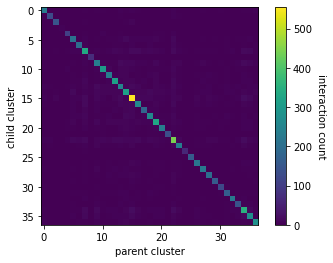

In [240]:
fig, ax = plt.subplots()
im = ax.imshow(intx_matrix)
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_xlabel('parent cluster')
ax.set_ylabel('child cluster')
cbar.ax.set_ylabel('interaction count', rotation=-90, va="bottom")
plt.show()

In [250]:
intx_matrix, intx_subreddit_ranking = community_interaction_data(year_one_actions, 
                                                                 year_one_cluster_dict, 
                                                                 2020, 
                                                                 len(comm_year_one))
posts_ranking, user_rankings, number_subreddits = community_subreddit_data(comm_year_one, 2020)
for ranking in range(len(posts_ranking)):
    print(len(comm_year_one[ranking]), posts_ranking[ranking])
    print(user_rankings[ranking])
    print(intx_subreddit_ranking[ranking])

58 {'BattleForDreamIsland': 227, 'meme': 118, 'lisathepainfulrpg': 116, 'Gamemeneersubmissies': 55, 'teenagers': 51}
{'teenagers': 14, 'Minecraft': 14, 'aww': 11, 'mildlyinfuriating': 11, 'funny': 11}
{'memes': 28, 'BattleForDreamIsland': 24, 'AskReddit': 22, 'JeepCherokeeXJ': 18, 'Minecraft': 18}
25 {'TNOmod': 69, 'BOLIVIA': 40, 'PoliticalCompassMemes': 26, 'ExplainAGamePlotBadly': 24, 'vexillology': 21}
{'Showerthoughts': 9, 'AskHistorians': 6, 'NoStupidQuestions': 6, 'cursedcomments': 5, 'mildlyinteresting': 5}
{'TNOmod': 32, 'vexillology': 12, 'Jreg': 10, 'RedWorldMod': 10, 'RedFloodMod': 8}
9 {'SMG4': 523, 'MetaRunner': 41, 'Undertale': 26, 'transformers': 25, 'Transformemes': 14}
{'gaming': 5, 'SMG4': 4, 'MetaRunner': 3, 'teenagers': 3, 'NintendoMemes': 2}
{'SMG4': 130, 'nextfuckinglevel': 6, 'tf2memes': 4, 'MetaRunner': 2, 'Unexpected': 2}
4 {'SyrianCirclejerkWar': 122, 'armenia': 88, 'rojava': 62, 'science': 35, 'worldnews': 21}
{'news': 2, 'worldnews': 2, 'HistoryMemes': 2, 'a

In [253]:
# explore level of resolution for Louvain
print(len(number_subreddits))

14508


In [ ]:
# sub-subreddit communities
# what underlies community formation -- is subreddit weighted more heavily moreso than # interaction?
# cross subreddit interaction
# how is the activity of top 200 subreddits divided 

#TO DOs
# lots of reading, find better ways to measure how graphs change over time vs. Louvain
# understand what is weighted the most in Louvain community detection irrespective of time
# get granular metrics from existing data
# if time, expand to all users active in at least 10 subreddits (vs. 0.1%)